In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Data_Colab/MIR')

Mounted at /content/drive/


In [2]:
!pip install mir_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100718 sha256=efbf3f33ae7aa611e06c5ce729abf409c41bcf9f0c4c4c04caee8c76cac55270
  Stored in directory: /root/.cache/pip/wheels/e9/f5/d5/eb3db1d056253da195208853842bce745a84b29f44cab59b6c
Successfully built mir_eval


In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from math import sin, cos, radians
from itertools import repeat
import pandas as pd
import mir_eval
import scipy.linalg
from typing import List
from scipy.stats import zscore
from dataclasses import dataclass
# import librosa.display

##Question 1

In [ ]:
#(lala land): https://www.youtube.com/watch?v=oAXXSFKfjLs&ab_channel=TheTheorist
y, sr = librosa.load('question1.mp3', sr=22050) #librosa's sr=22050
f0, voiced_flag, voiced_probs = librosa.pyin(y, 
                                            #  sr=44100, frame_length=1024,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=22050)

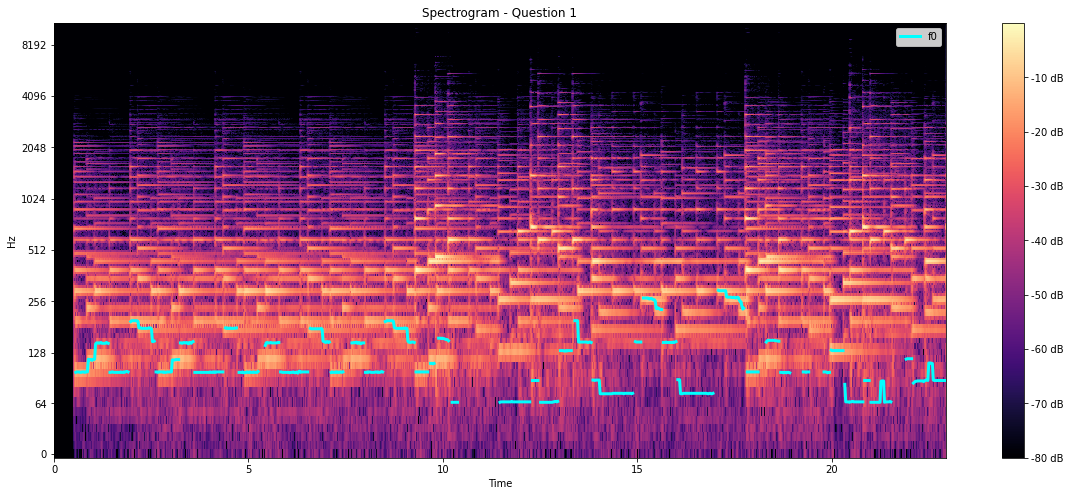

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(20, 8))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Spectrogram - Question 1')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')
plt.savefig('question1_spectrogram.png')


Question 1c

In [4]:
t = np.linspace(0, 10, 80000)
x1 = np.sin(2000*t**2)
x2 = np.sin(2000 * t + (10 * np.sin(2.5 * t**2)))
sf.write('question1c_x1.wav', x1, 8000)
sf.write('question1c_x2.wav', x2, 8000)

if1 = (2000*t)/(np.pi)
if2 = (2000 + 50 * t * np.cos(2.5 * t **2))/(2*np.pi)

Question 1d

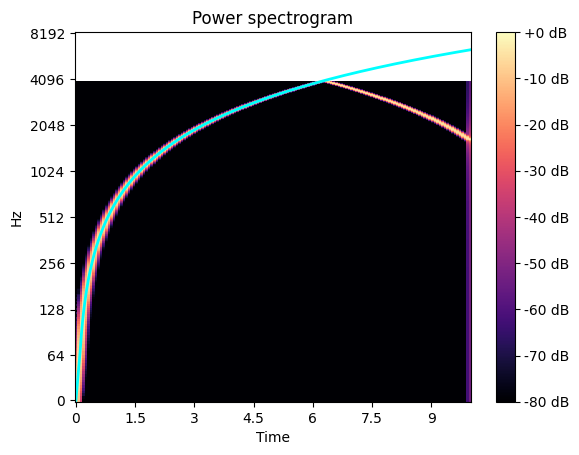

In [7]:
S = np.abs(librosa.stft(x1,hop_length=512, win_length=2048))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=8000, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
ax.plot(t, if1, label='IF', color='cyan', linewidth=2)
fig.colorbar(img, ax=ax, format="%+2.0f dB")

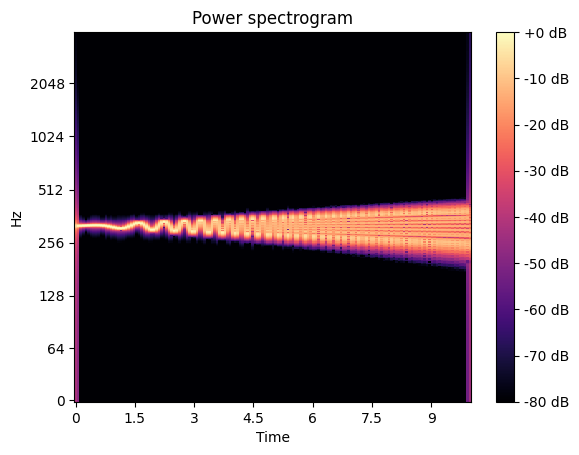

In [55]:
S = np.abs(librosa.stft(x2,hop_length=512, win_length=2048))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=8000, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

##Question 2a

In [16]:
@dataclass
class KeyEstimator:
    major = np.asarray(
        [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    )
    minor = np.asarray(
        [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    )

    def __init__(self):
        self.major = zscore(self.major)
        self.major_norm = scipy.linalg.norm(self.major)
        self.major = scipy.linalg.circulant(self.major)

        self.minor = zscore(self.minor)
        self.minor_norm = scipy.linalg.norm(self.minor)
        self.minor = scipy.linalg.circulant(self.minor)

    def __call__(self, x: np.array) -> List[np.array]:

        x = zscore(x)
        x_norm = scipy.linalg.norm(x)

        coeffs_major = self.major.T.dot(x) / self.major_norm / x_norm
        coeffs_minor = self.minor.T.dot(x) / self.minor_norm / x_norm

        return coeffs_major, coeffs_minor

In [17]:
key_to_note = {0:"C",1:"C#/Db",2:"D",3:"D#/Eb",4:"E",5:"F",6:"F#/Gb",7:"G",8:"G#/Ab",9:"A",10:"A#/Bb",11:"B"}
note_to_key = {"C":0,"C#":1, "Db":1,"D":2,"D#":3,"Eb":3,"E":4,"F":5,"F#":6, "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11}

In [18]:
ann = pd.read_csv("./SWD_SC06/02_Annotations/ann_audio_globalkey_2.csv")
data = ann["WorkID;PerformanceID;key"].to_numpy()

names = []
strr = []
keys = []
modes = []
for item in data:
    listt = item.replace('"','').replace("'",'').split(';')
    if listt[1] == 'SC06':
        names.append(listt[0])
        strr_list = listt[2].split(':')
        keys.append(note_to_key[strr_list[0]])
        if strr_list[1] == 'min':
            modes.append('minor')
        else: modes.append('major')
        strr.append(key_to_note[keys[-1]] + ' ' + modes[-1])
df_ann = pd.DataFrame(list(zip(names, strr, keys, modes)), columns =['Filename', 'org_str','org_key', 'org_mode'])

In line 6, one can change chroma_stft to cqt, cens if necessary, but stft have the best performance in both RA and WA score.

Predict with all music pieces.

In [ ]:
pred_str = []
pred_key = []
pred_mode = []
for file in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']:
    y, sr = librosa.load('./SWD_SC06/01_RawData/audio_wav/SC06/Schubert_D911-' + file + '_SC06.wav')
    chroma = librosa.feature.chroma_stft(y=y, sr=sr) #length = 12 for 12 keys    
    chromagram = chroma.sum(axis=1) #late fusion
    key_estimator = KeyEstimator()
    maj, min = key_estimator(chromagram)

    pred = key_to_note[np.argmax(maj)] + ' major' if np.max(maj) > np.max(min) else key_to_note[np.argmax(min)] + ' minor'
    pred_str.append(pred)

    if len(pred.split(' ')[0]) > 3: #if there are two notes like A#/Bb
        pred_key.append(note_to_key[pred.split(' ')[0].split('/')[0]])
    else: 
        pred_key.append(note_to_key[pred.split(' ')[0]])
    pred_mode.append(pred.split(' ')[1])

Create a df_final with ground truth and my predictions.

In [49]:
df_final = pd.concat([df_ann['Filename'], df_ann['org_str'],df_ann['org_key'], df_ann['org_mode'], 
                    pd.Series(pred_str), pd.Series(pred_key), pd.Series(pred_mode)], 
                    keys = ["Filename", "org_str","org_key", 'org_mode', "pred_str", "pred_key", "pred_mode"],
                    axis=1)
df_final

,Filename,org_str,org_key,org_mode,pred_str,pred_key,pred_mode
0,Schubert_D911-01,C minor,0,minor,C minor,0,minor
1,Schubert_D911-02,G minor,7,minor,G minor,7,minor
2,Schubert_D911-03,D#/Eb minor,3,minor,D#/Eb minor,3,minor
3,Schubert_D911-04,A#/Bb minor,10,minor,A#/Bb minor,10,minor
4,Schubert_D911-05,D major,2,major,A major,9,major
5,Schubert_D911-06,D minor,2,minor,D minor,2,minor
6,Schubert_D911-07,D minor,2,minor,A major,9,major
7,Schubert_D911-08,F minor,5,minor,C major,0,major
8,Schubert_D911-09,A minor,9,minor,A minor,9,minor
9,Schubert_D911-10,A#/Bb minor,10,minor,A#/Bb minor,10,minor


In [50]:
correct_count = 0
for i in range(len(df_final)):
    if df_final.loc[i,'org_key'] == df_final.loc[i,'pred_key'] and df_final.loc[i,'org_mode'] == df_final.loc[i,'pred_mode']:
        correct_count += 1
ra_global = correct_count / len(df_final)
ra_global

0.625

In [51]:
scores = 0
for i in range(len(df_final)):
    ref = df_final['org_str'][i]
    if len(ref) > 10:
        ref_list = ref.split(' ')
        ref = ref_list[0].split('/')[0] + ' ' + ref_list[1]

    est = df_final['pred_str'][i]
    if len(est) > 10:
        est_list = est.split(' ')
        est = est_list[0].split('/')[0] + ' ' + est_list[1]

    scores += mir_eval.key.weighted_score(ref, est)

wa_score = scores / len(df_final)
wa_score

0.6875

## Question 2b

In [4]:
@dataclass
class KeyEstimator:
    major = np.asarray(
        [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    )
    minor = np.asarray(
        [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    )

    def __init__(self):
        self.major = zscore(self.major)
        self.major_norm = scipy.linalg.norm(self.major)
        self.major = scipy.linalg.circulant(self.major)

        self.minor = zscore(self.minor)
        self.minor_norm = scipy.linalg.norm(self.minor)
        self.minor = scipy.linalg.circulant(self.minor)

    def __call__(self, x: np.array) -> List[np.array]:

        x = zscore(x)
        x_norm = scipy.linalg.norm(x)

        coeffs_major = self.major.T.dot(x) / self.major_norm / x_norm
        coeffs_minor = self.minor.T.dot(x) / self.minor_norm / x_norm

        return coeffs_major, coeffs_minor

In [5]:
key_to_note = {0:"C",1:"C#/Db",2:"D",3:"D#/Eb",4:"E",5:"F",6:"F#/Gb",7:"G",8:"G#/Ab",9:"A",10:"A#/Bb",11:"B"}
note_to_key = {"C":0,"C#":1, "Db":1,"D":2,"D#":3,"Eb":3,"E":4,"F":5,"F#":6, "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11}

Get ground truth values from the csv files and create a df_ann dataframe.

In [6]:
names = []
start = []
end = []
strr = []
keys = []
modes = []

for file in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']:
    ann = pd.read_csv("./SWD_SC06/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-"+file+"_SC06.csv")
    data = ann['start;end;key'].to_numpy()
    for item in data:
        names.append("Schubert_D911-"+file)
        listt = item.replace('"','').split(';')
        start.append(float(listt[0]))
        end.append(float(listt[1]))
        strr_list = listt[2].split(':')
        keys.append(note_to_key[strr_list[0]])
        if strr_list[1] == 'min':
            strr.append(key_to_note[note_to_key[strr_list[0]]] + ' minor')
            modes.append('minor')
        else: 
            strr.append(key_to_note[note_to_key[strr_list[0]]] + ' major')
            modes.append('major')
        
df_ann = pd.DataFrame(list(zip(names, start, end, strr, keys, modes)), columns =['Filename', 'start', 'end', 'org_str','org_key', 'org_mode'])
# df_ann

Extract smaller music frame and do predictions with them, create a df_pred dataframe.

In [9]:
pred_file = []
pred_time = []
pred_str = []
pred_key = []
pred_mode = []

duration = int(30 / 2)
for file in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']:
    y, sr = librosa.load('./SWD_SC06/01_RawData/audio_wav/SC06/Schubert_D911-' + file + '_SC06.wav')
    segments = len(y) // (22050 * duration)
    indexes = []
    for i in range(1, segments + 1):
        pred_file.append('Schubert_D911-' + file)
        start = ((i-1) * duration * 22050)
        end = ((i+1) * duration * 22050)
        pred_time.append(i * duration)

        # extract frames and do prediction
        tmp_y = y[start:end]
        chroma = librosa.feature.chroma_cens(y=tmp_y, sr=sr) #length = 12 for 12 keys    
        chromagram = chroma.sum(axis=1)
        key_estimator = KeyEstimator()
        maj, min = key_estimator(chromagram)
        pred = key_to_note[np.argmax(maj)] + ' major' if np.max(maj) > np.max(min) else key_to_note[np.argmax(min)] + ' minor'
        pred_str.append(pred)

        if len(pred.split(' ')[0]) > 3:
            pred_key.append(note_to_key[pred.split(' ')[0].split('/')[0]])
        else: 
            pred_key.append(note_to_key[pred.split(' ')[0]])
        pred_mode.append(pred.split(' ')[1])

df_pred = pd.DataFrame(list(zip(pred_file, pred_time, pred_str, pred_key, pred_mode)), columns =['Filename', 'time', 'pred_str','pred_key', 'pred_mode'])
# df_pred

Calculating RA/WA score

In [10]:
ra_count = 0
wa_score = 0
for file in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']:
    org_tmp = df_ann[df_ann['Filename'] == 'Schubert_D911-' + file].reset_index()
    pred_tmp = df_pred[df_pred['Filename'] == 'Schubert_D911-' + file].reset_index()

    for i in range(len(pred_tmp)):
        check_time = pred_tmp['time'][i]
        dur_idx = org_tmp.index[(org_tmp['start'] <= check_time) & (org_tmp['end'] >= check_time)].to_list()
        if len(dur_idx): dur_idx = dur_idx[0]
        else: break

        # add to ra count
        if pred_tmp['pred_key'][i] == org_tmp['org_key'][dur_idx]:
            if pred_tmp['pred_mode'][i] == org_tmp['org_mode'][dur_idx]:
                ra_count += 1
        # add to wa
        ref = org_tmp['org_str'][dur_idx]
        if len(ref) > 10:
            ref = ref.split(' ')[0].split('/')[0] + ' ' + ref.split(' ')[1]

        est = pred_tmp['pred_str'][i]
        if len(est) > 10:
            est = est.split(' ')[0].split('/')[0] + ' ' + est.split(' ')[1]
        wa_score += mir_eval.key.weighted_score(ref, est)

print('FINAL RA', ra_count / len(df_pred))
print('FINAL WA', wa_score / len(df_pred))


FINAL RA 0.47410358565737054
FINAL WA 0.5880478087649403
